## Initial analysis to help support NOAA COM/CPO FY23 Proposal 

In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import time
import warnings
from datetime import date, timedelta
import metpy.calc as mpc
from metpy import interpolate
from metpy.units import units
import numpy as np
import pandas as pd
import scipy.stats as stats
import xarray as xr
import seaborn as sns
warnings.filterwarnings('ignore')
## Import Ngl with pyn_env active 
# import Ngl


import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable



In [2]:
def preprocess_LES(ds):
    keepVars = ['XTIME','AVS_SH','AVS_LH','AVS_LWP','AVS_RAIN','AVP_QC','AVP_QV',
                'AVP_Z','AVP_P','AVP_THL','AVP_TH','AVP_LWC','AVP_IWC']
    
    dsTimes = ds.Times.load()
    
    times = []
    for iT in range(len(dsTimes.values)):
        timeNow = datetime.datetime.strptime(dsTimes.astype(str).values[iT], '%Y-%m-%d_%H:%M:%S')
        times   = np.append(times, timeNow)

    ds = ds.assign_coords({"Time": times, 
                           "west_east": (ds.west_east.load().values)*0.250,
                           "south_north": (ds.south_north.load().values)*0.250})
    
    ## Convert to local time and drop first time 
    ds['Time'] = ds['Time'].values - np.timedelta64(5, 'h') # And convert to local time by -5hrs 

#     iTimes = np.where(testDS['Time'].values >= (testDS['Time'].values[0] + np.timedelta64(1, 'h')) )[0]
#     testDS = testDS.isel(Time=iTimes)
    
    return ds[keepVars].load()


# LES stuff

## Read in data

In [3]:
# forcingFile  = '/glade/work/mdfowler/CLASP/clasp-htg.bdate.nc'
# forcDS       = xr.open_dataset(forcingFile, decode_times=True)

# ## Convert to local time
# localTimes  = forcDS['time'].values - np.timedelta64(5,'h')
# forcDS      = forcDS.assign_coords({"time": localTimes})

# ## Can we get a measure of vertically integrated moisture/temperature convergence? 
# g = 9.8 
# vertInt_T_adv_h = np.zeros([len(forcDS.time.values)])
# vertInt_Q_adv_h = np.zeros([len(forcDS.time.values)])

# for iP in range(len(forcDS.lev.values)-1):
#     dP = (forcDS.lev.values[iP]-forcDS.lev.values[iP+1])*100.0 # Convert from hPa to Pa

#     ## Adding a negative sign outside of the advective terms - 
#     ##   These are the values of T and Q divergence, so their negative is *convergence* and easier to interpret
#     vertInt_Tadv_levl = dP*(-forcDS.T_adv_h.values[:,iP,0,0]/3600.0) # Convert T_adv units from K/hr to K/s
#     vertInt_Qadv_levl = dP*(-forcDS.q_adv_h.values[:,iP,0,0]/3600.0) # Convert Q_adv units from g/kg/hr to g/kg/s

#     # Sum over all the levels 
#     vertInt_T_adv_h = vertInt_T_adv_h + vertInt_Tadv_levl
#     vertInt_Q_adv_h = vertInt_Q_adv_h + vertInt_Qadv_levl

# vertInt_T_adv_h = vertInt_T_adv_h/g
# vertInt_Q_adv_h = vertInt_Q_adv_h/g

# forcDS['vertInt_T_adv_h'] = (('time'), vertInt_T_adv_h)
# forcDS['vertInt_Q_adv_h'] = (('time'), vertInt_Q_adv_h)




Read in the secondary circulation metric that Jason's calculated, and the files with the domain-wide averaged higher order moments. 

In [4]:
circulationTXT = '/glade/work/mdfowler/CLASP/LESdata_fromJason/circulations.txt'

circMetric = pd.read_csv(circulationTXT, sep=" ", header=None)
circMetric.columns = ['dateVal', 'metricVal']

allYears   = [] 
allMonths  = []
allDays    = []

for iDate in range(len(circMetric.dateVal)):
    allYears   = np.append(allYears,   circMetric.dateVal.values.astype(str)[iDate][0:4]) 
    allMonths  = np.append(allMonths, circMetric.dateVal.values.astype(str)[iDate][4:6])
    allDays    = np.append(allDays, circMetric.dateVal.values.astype(str)[iDate][6::])



In [5]:
lesDir        = '/glade/work/mdfowler/CLASP/LESdata_fromJason/allDays_250mRes/'

## Fix time arrays to be useful in the LES cases
startTime = datetime.datetime(2016,1,1, 0,0,0)

# Empty arrays: 
dateStringsUsed   = []
circMetric_daysUsed = []
circMetric_daysUsed_defMatch = []
daysWithDefault = []
dailymax_LES_thl2 = []

## Counter for how many days have default output
numDaysDefault = 0
dayCounts = 0 

for iDay in range(len(allYears)): 
     
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    ## First: read LES data (surface thl2 and qv2) 
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    dateString = allYears[iDay]+allMonths[iDay]+allDays[iDay]
    
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    ## Get LES data
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    HTGds_allVars = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_00.nc', decode_times=False)
    HMGds_allVars = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_01.nc', decode_times=False)

    HTGds_allVars = HTGds_allVars.assign_coords({"case": 'HTG'})
    HMGds_allVars = HMGds_allVars.assign_coords({"case": 'HMG'})

    LES_allVars = xr.concat([HMGds_allVars, HTGds_allVars], "case")



    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    ## Just a few more processing steps 
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

    ## Get a better time dimension to use  (LES)
    times_LESday = [] 
    for iT in range(len(LES_allVars.time.values)): 
        timeStep     = startTime + timedelta(minutes = int(LES_allVars.time.values[iT])) - timedelta(hours = 5)   ## Also convert to local time 
        times_LESday = np.append(times_LESday, timeStep)


    LES_allVars['datetime'] = (('time'), times_LESday)
    LES_allVars             = LES_allVars.set_index(time='datetime')

    ## Combine into one array 
    if dayCounts==0: 
        LES_allDays_allVars = LES_allVars
    else:
        LES_allDays_allVars = xr.concat([LES_allDays_allVars, LES_allVars], "time")
    dayCounts = dayCounts+1

    del LES_allVars

    print('Done with ', dateString)

    

Done with  20150606
Done with  20150609
Done with  20150627
Done with  20150801
Done with  20150829
Done with  20160518
Done with  20160530
Done with  20160610
Done with  20160611
Done with  20160614
Done with  20160619
Done with  20160625
Done with  20160716
Done with  20160719
Done with  20160720
Done with  20160818
Done with  20160819
Done with  20160830
Done with  20170403
Done with  20170405
Done with  20170509
Done with  20170524
Done with  20170527
Done with  20170605
Done with  20170609
Done with  20170614
Done with  20170626
Done with  20170627
Done with  20170629
Done with  20170630
Done with  20170704
Done with  20170705
Done with  20170709
Done with  20170712
Done with  20170716
Done with  20170717
Done with  20170719
Done with  20170720
Done with  20170721
Done with  20170725
Done with  20170728
Done with  20170802
Done with  20170826
Done with  20170828
Done with  20170830
Done with  20170922
Done with  20170923
Done with  20170924
Done with  20180514
Done with  20180522


In [6]:
## Resample the moments to be hourly (means are listed for the hour they start in; so "8a" =mean over 8a, 8:10, 8:20, etc) 
LES_allDays_allVarsHr         = LES_allDays_allVars.resample(time='1H').mean(dim='time').dropna(dim='time')
LES_allDays_allVars30m        = LES_allDays_allVars.resample(time='30Min').mean(dim='time').dropna(dim='time')

## Add thirty minutes to match the other LES output better 
LES_allDays_allVarsHr['time'] = LES_allDays_allVarsHr['time'] + np.timedelta64(30, 'm')

## For consistency with default LES cases, let's also only get means through hour 21
iHrsSel               = np.where(LES_allDays_allVarsHr['time.hour'].values<22)[0]
LES_allDays_allVarsHr = LES_allDays_allVarsHr.isel(time=iHrsSel)


Read in the 'default' LES variables that are available on the Duke server

In [7]:
newLESdefDir = '/glade/campaign/cgd/tss/mdfowler/CLASP_LES_data/hydrology.cee.duke.edu/'
HTGdirs      = np.sort(glob.glob(newLESdefDir+'fr2_*_00'))
HMGdirs      = np.sort(glob.glob(newLESdefDir+'fr2_*_01'))


for iHTG in range(len(HTGdirs)):
    filesHTG  = np.sort(glob.glob(HTGdirs[iHTG]+'/*.nc4'))
    
    htgLESnew = xr.open_mfdataset(filesHTG,  preprocess=preprocess_LES, concat_dim='Time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')

    if iHTG==0:
        HTGnew_allDays = htgLESnew
    else:
        HTGnew_allDays = xr.concat([HTGnew_allDays, htgLESnew], "Time")
    
    
    
for iHMG in range(len(HMGdirs)):    
    filesHMG = np.sort(glob.glob(HMGdirs[iHMG]+'/*.nc4'))

    hmgLESnew = xr.open_mfdataset(filesHMG,  preprocess=preprocess_LES, concat_dim='Time', 
                                    combine='nested', decode_times=False, 
                                    data_vars='minimal')
    
    if iHMG==0:
        HMGnew_allDays = hmgLESnew
    else:
        HMGnew_allDays = xr.concat([HMGnew_allDays, hmgLESnew], "Time")
        

print('Done reading in new LES cases')

HTGnew_allDays = HTGnew_allDays.assign_coords({"case": 'HTG'})
HMGnew_allDays = HMGnew_allDays.assign_coords({"case": 'HMG'})

LES_newDefault = xr.concat([HMGnew_allDays, HTGnew_allDays], "case")


Done reading in new LES cases


In [8]:
## Drop the first hour (7a) - this is just the initial state, not LES simulated 
iHrsSel        = np.where(LES_newDefault['Time.hour'].values>7)[0]
LES_newDefault = LES_newDefault.isel(Time=iHrsSel)

## LES times were recorded at the *end* of the hour, so just shift into the hour's mean they represent 
LES_newDefault['Time'] = LES_newDefault.Time - np.timedelta64(30, 'm')


In [9]:
uniqDays_LES  = LES_newDefault.sel(case='HMG').resample(Time='1D').mean().dropna(dim='Time').Time.values
uniqDays_moms = LES_allDays_allVarsHr.sel(case='HMG').resample(time='1D').mean().dropna(dim='time').time.values

print('Number of days in LES default data: ', len(uniqDays_LES))
print('Number of ', len(uniqDays_moms))
print('Number of overlapping days: ', len(list(set(uniqDays_LES) & set(uniqDays_moms) )))

Number of days in LES default data:  92
Number of  92
Number of overlapping days:  92


## Look into HTG vs HMG differences

Get total TKE in the LES simulations

In [10]:
## u2 and v2 are on the same vertical grid, but w2 is not. Problem is that I don't have pressure levels for 
##    those inbetween levels 

## Interpolate w2 to those heights? 
hgtGoal = LES_allDays_allVarsHr.z
hgtNow  = LES_allDays_allVarsHr.zw

interpW2 = np.full([len(LES_allDays_allVarsHr.time.values),
                    len(LES_allDays_allVarsHr.case.values), len(LES_allDays_allVarsHr.k.values)], np.nan)

for iCase in range(len(LES_allDays_allVarsHr.case.values)): 
    for iT in range(len(LES_allDays_allVarsHr.time.values)):
        zTime = hgtGoal[iT,:].isel(case=iCase).values
        zNow  = hgtNow[iT,:].isel(case=iCase).values
        w2Now = LES_allDays_allVarsHr.w2.isel(case=iCase).values[iT,:]

        interpW2[iT, iCase, :] = interpolate.interpolate_1d(zTime, zNow, w2Now)

LES_allDays_allVarsHr['interp_w2'] = (('time','case','k'), interpW2)
TKE_total = LES_allDays_allVarsHr.u2.values + LES_allDays_allVarsHr.v2.values + LES_allDays_allVarsHr.interp_w2.values

LES_allDays_allVarsHr['TKE_total'] = (('time','case','k'), TKE_total)


In [11]:
LESmeanRain     = LES_newDefault['AVS_RAIN'].mean(("south_north", "west_east"))
LES_newDefault['meanRain'] = (('case','Time'), LESmeanRain*3600)  ## Convert units to mm/hr, not mm/s


Get hourly means and some way of estimating significance

In [12]:
hourlyMean_LESdef  = LES_newDefault.groupby('Time.hour').mean(dim='Time')
hourlyStd_LESdef   = LES_newDefault.groupby('Time.hour').std(dim='Time')
hourlyCount_LESdef = LES_newDefault.groupby('Time.hour').count(dim='Time')
hourlySE_LESdef    = hourlyStd_LESdef/np.sqrt(hourlyCount_LESdef)

hourlyMean_LESmom  = LES_allDays_allVarsHr.groupby('time.hour').mean(dim='time')
hourlyStd_LESmom   = LES_allDays_allVarsHr.groupby('time.hour').std(dim='time')
hourlyCount_LESmom = LES_allDays_allVarsHr.groupby('time.hour').count(dim='time')
hourlySE_LESmom    = hourlyStd_LESmom/np.sqrt(hourlyCount_LESmom)


In [13]:
CIlevel = 1.960   ## 95% CI
# CIlevel = 1.645   ## 90% CI

Text(0, 0.5, 'mm/hr')

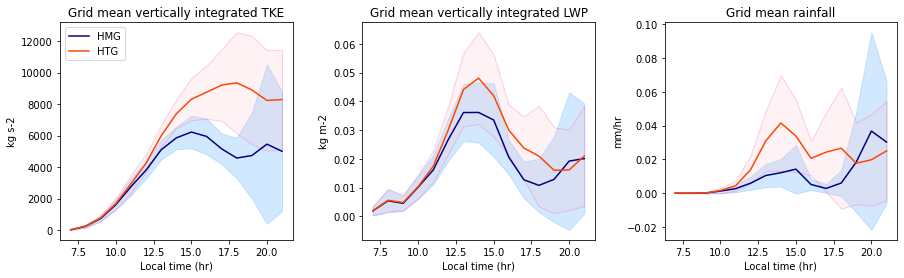

In [14]:
## Plot differences in the annual cycle of rainfall 

fig,axs = plt.subplots(1,3, figsize=(15,4))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.3)


## TKE 
axs[0].plot(hourlyMean_LESmom.hour.values, hourlyMean_LESmom.sel(case='HMG').tke.values, '-', color='navy', label='HMG')
axs[0].fill_between(hourlyMean_LESmom.hour.values, 
                 hourlyMean_LESmom.sel(case='HMG').tke.values - (CIlevel*hourlySE_LESmom.sel(case='HMG').tke.values), 
                 hourlyMean_LESmom.sel(case='HMG').tke.values + (CIlevel*hourlySE_LESmom.sel(case='HMG').tke.values),
                 alpha=0.2, facecolor='dodgerblue',edgecolor='dodgerblue')
axs[0].plot(hourlyMean_LESmom.hour.values, hourlyMean_LESmom.sel(case='HTG').tke.values, '-', color='orangered', label='HTG')
axs[0].fill_between(hourlyMean_LESmom.hour.values, 
                 hourlyMean_LESmom.sel(case='HTG').tke.values - (CIlevel*hourlySE_LESmom.sel(case='HTG').tke.values), 
                 hourlyMean_LESmom.sel(case='HTG').tke.values + (CIlevel*hourlySE_LESmom.sel(case='HTG').tke.values),
                 alpha=0.2, facecolor='pink',edgecolor='deeppink')
axs[0].legend(loc='upper left')
axs[0].set_title('Grid mean vertically integrated TKE')
axs[0].set_xlabel('Local time (hr)')
axs[0].set_ylabel(LES_allDays_allVars.tke.units)


## LWP
axs[1].plot(hourlyMean_LESmom.hour.values, hourlyMean_LESmom.sel(case='HMG').lwp.values, '-', color='navy', label='HMG')
axs[1].fill_between(hourlyMean_LESmom.hour.values, 
                 hourlyMean_LESmom.sel(case='HMG').lwp.values - (CIlevel*hourlySE_LESmom.sel(case='HMG').lwp.values), 
                 hourlyMean_LESmom.sel(case='HMG').lwp.values + (CIlevel*hourlySE_LESmom.sel(case='HMG').lwp.values),
                 alpha=0.2, facecolor='dodgerblue',edgecolor='dodgerblue')
axs[1].plot(hourlyMean_LESmom.hour.values, hourlyMean_LESmom.sel(case='HTG').lwp.values, '-', color='orangered', label='HTG')
axs[1].fill_between(hourlyMean_LESmom.hour.values, 
                 hourlyMean_LESmom.sel(case='HTG').lwp.values - (CIlevel*hourlySE_LESmom.sel(case='HTG').lwp.values), 
                 hourlyMean_LESmom.sel(case='HTG').lwp.values + (CIlevel*hourlySE_LESmom.sel(case='HTG').lwp.values),
                 alpha=0.2, facecolor='pink',edgecolor='deeppink')
# axs[1].legend()
axs[1].set_title('Grid mean vertically integrated LWP')
axs[1].set_xlabel('Local time (hr)')
axs[1].set_ylabel(LES_allDays_allVars.lwp.units)


## Grid mean rainfall
axs[2].plot(hourlyMean_LESdef.hour.values, hourlyMean_LESdef.sel(case='HMG').meanRain.values, color='navy', label='HMG')
axs[2].fill_between(hourlyMean_LESdef.hour.values, 
                 hourlyMean_LESdef.sel(case='HMG').meanRain.values - (CIlevel*hourlySE_LESdef.sel(case='HMG').meanRain.values), 
                 hourlyMean_LESdef.sel(case='HMG').meanRain.values + (CIlevel*hourlySE_LESdef.sel(case='HMG').meanRain.values),
                 alpha=0.2, facecolor='dodgerblue',edgecolor='dodgerblue')
axs[2].plot(hourlyMean_LESdef.hour.values, hourlyMean_LESdef.sel(case='HTG').meanRain.values, color='orangered', label='HTG')
axs[2].fill_between(hourlyMean_LESdef.hour.values, 
                 hourlyMean_LESdef.sel(case='HTG').meanRain.values - (CIlevel*hourlySE_LESdef.sel(case='HTG').meanRain.values), 
                 hourlyMean_LESdef.sel(case='HTG').meanRain.values + (CIlevel*hourlySE_LESdef.sel(case='HTG').meanRain.values),
                 alpha=0.2, facecolor='pink',edgecolor='deeppink')
# axs[2].legend()
axs[2].set_title('Grid mean rainfall')
axs[2].set_xlabel('Local time (hr)')
# axs[2].set_ylabel(LES_newDefault.AVS_RAIN.units)
axs[2].set_ylabel('mm/hr')



[None, None, None, None]

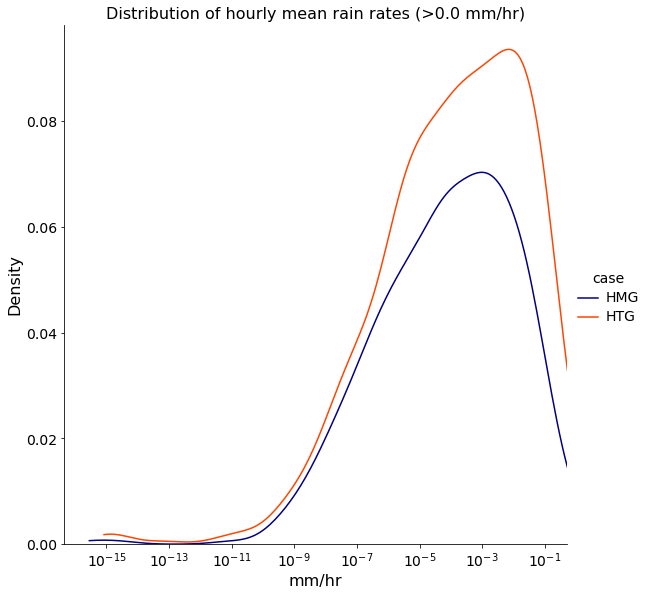

In [49]:
# Define dataframe

rainRatesHMG = LES_newDefault.meanRain.sel(case='HMG').values
rainRatesHMG = rainRatesHMG[np.where(rainRatesHMG>0)[0]]

rainRatesHTG = LES_newDefault.meanRain.sel(case='HTG').values
rainRatesHTG = rainRatesHTG[np.where(rainRatesHTG>0)[0]]

# dfReal = pd.concat(axis=0, ignore_index=True, objs=[
#          pd.DataFrame.from_dict({'Rain rate': np.squeeze(LES_newDefault.meanRain.sel(case='HMG').values), 'case': 'HMG'}),
#          pd.DataFrame.from_dict({'Rain rate': np.squeeze(LES_newDefault.meanRain.sel(case='HTG').values), 'case': 'HTG'}),
# ])

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHMG), 'case': 'HMG'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTG), 'case': 'HTG'}),
])

# Make plot 
g = sns.displot(dfReal, x='Rain rate', hue='case', kind='kde', height=8, cut=0, 
                log_scale=True,
# g = sns.displot(dfReal, x='Rain rate', hue='case', kind='ecdf', height=8, 
                palette=['navy','orangered'])


g.ax.set_xlim([0,0.5])
g.ax.set_title("Distribution of hourly mean rain rates (>0.0 mm/hr)", fontsize=16 ) 
g.ax.set_xlabel('mm/hr',fontsize=16)
g.ax.set_ylabel('Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=14)


[None, None, None, None]

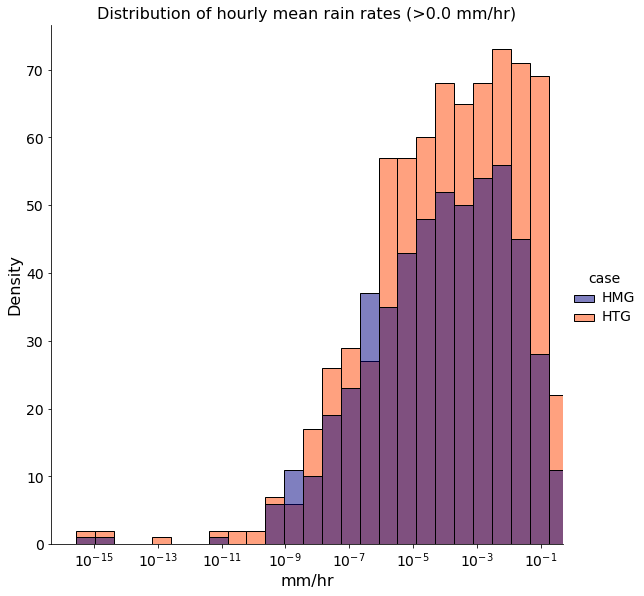

In [50]:
# Define dataframe

rainRatesHMG = LES_newDefault.meanRain.sel(case='HMG').values
rainRatesHMG = rainRatesHMG[np.where(rainRatesHMG>0)[0]]

rainRatesHTG = LES_newDefault.meanRain.sel(case='HTG').values
rainRatesHTG = rainRatesHTG[np.where(rainRatesHTG>0)[0]]

# dfReal = pd.concat(axis=0, ignore_index=True, objs=[
#          pd.DataFrame.from_dict({'Rain rate': np.squeeze(LES_newDefault.meanRain.sel(case='HMG').values), 'case': 'HMG'}),
#          pd.DataFrame.from_dict({'Rain rate': np.squeeze(LES_newDefault.meanRain.sel(case='HTG').values), 'case': 'HTG'}),
# ])

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHMG), 'case': 'HMG'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTG), 'case': 'HTG'}),
])

# Make plot 
g = sns.displot(dfReal, x='Rain rate', hue='case', kind='hist', height=8, 
                log_scale=True,
# g = sns.displot(dfReal, x='Rain rate', hue='case', kind='ecdf', height=8, 
                palette=['navy','orangered'])


g.ax.set_xlim([0,0.5])
g.ax.set_title("Distribution of hourly mean rain rates (>0.0 mm/hr)", fontsize=16 ) 
g.ax.set_xlabel('mm/hr',fontsize=16)
g.ax.set_ylabel('Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=14)


[None, None, None, None]

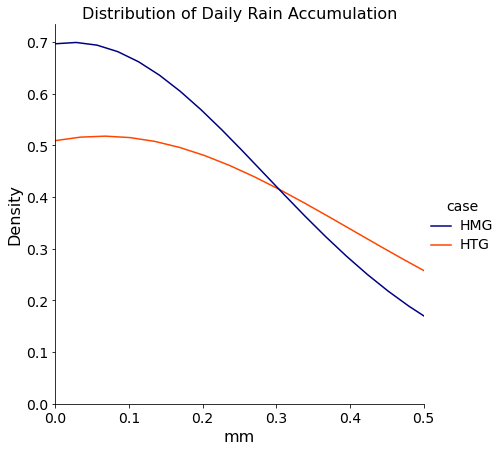

In [33]:
dailyRainSum = LES_newDefault.meanRain.resample(Time='1D').sum(dim='Time').dropna(dim='Time') 

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(dailyRainSum.sel(case='HMG').values), 'case': 'HMG'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(dailyRainSum.sel(case='HTG').values), 'case': 'HTG'}),
])

# Make plot 
g = sns.displot(dfReal, x='Rain rate', hue='case', kind='kde', height=6, cut=0,
                palette=['navy','orangered'])

# g = sns.displot(dfReal, x='Rain rate', hue='case', kind='hist', height=8,
#                 palette=['navy','orangered'])


g.ax.set_xlim([0,0.5])
g.ax.set_title("Distribution of Daily Rain Accumulation", fontsize=16 ) 
g.ax.set_xlabel('mm',fontsize=16)
g.ax.set_ylabel('Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=14)



Text(0.5, 0, 'HMG')

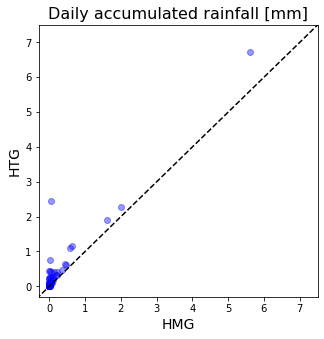

In [44]:
fig,axs = plt.subplots(1,1,figsize=(5,5))

axs.plot(dailyRainSum.sel(case='HMG').values, dailyRainSum.sel(case='HTG').values,'bo',alpha=0.4)
axs.plot(np.arange(-1,8,0.1), np.arange(-1,8,0.1),'k--')
axs.set_xlim([-0.3,7.5])
axs.set_ylim([-0.3,7.5])

axs.set_title('Daily accumulated rainfall [mm]', fontsize=16)
axs.set_ylabel('HTG', fontsize=14)
axs.set_xlabel('HMG', fontsize=14)


# Global CLASP stuff

In [ ]:
dataDir  = '/glade/campaign/cgd/tss/mdfowler/'   # Moved to more safe storage 

caseHTG  = 'globalCLASP.2000_CAM60_CLM50SP_CICEPRES_DOCNDOM_MOSART_SGLC_SWAV.f09_f09_mg17.HTG_cesm2p2.013'
caseHMG  = 'globalCLASP.2000_CAM60_CLM50SP_CICEPRES_DOCNDOM_MOSART_SGLC_SWAV.f09_f09_mg17.HMG_cesm2p2.013'
caseNone = 'globalCLASP.2000_CAM60_CLM50SP_CICEPRES_DOCNDOM_MOSART_SGLC_SWAV.f09_f09_mg17.NoMoments_cesm2p2.013'
caseHTG10 = 'globalCLASP.2000_CAM60_CLM50SP_CICEPRES_DOCNDOM_MOSART_SGLC_SWAV.f09_f09_mg17.HTG_mult10_cesm2p2.013match'

